In [1]:
import os
import pickle
import re

import matplotlib.lines as mlines
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import PyPDF2
import seaborn as sns
from IPython.display import Markdown, display
from matplotlib import colormaps
from matplotlib.cm import ScalarMappable
from matplotlib.colors import Normalize
from nltk import sent_tokenize, word_tokenize
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from seaborn import objects as so
from sklearn.decomposition import PCA
from tqdm.notebook import tqdm
from wordcloud import WordCloud
from IPython.display import Javascript

from classifier import Classifier
from node import Node, node_sum_sent
from scrapper import Scrapper

sns.set_style("darkgrid")

In [2]:
%reload_ext autoreload
%autoreload 2

# Read the data

In [3]:
pages = []
with open("ai-act-01.pdf", "rb") as pdf_file:
    read_pdf = PyPDF2.PdfReader(pdf_file)
    for page in read_pdf.pages:
        pages.append(page.extract_text())

print(pages[0])

EN   EN 
 
 
 EUROPEAN  
COMMISSION   
Brussels, 21.4.2021  
COM(2021) 206 final  
2021/0106 (COD)  
 
Proposal for a  
REGULATION OF THE EUROPEAN PARLIAMENT AND OF THE COUNCIL  
LAYING DOWN HARMONISED RULES ON ARTIFICIAL INTELLIGENCE 
(ARTIFICIAL INTELLIGENCE ACT) AND AMENDING CERTAIN UNION 
LEGISLATIVE ACTS  
{SEC(2021)  167 final}  - {SWD(2021)  84 final}  - {SWD(2021)  85 final}   


In [4]:
print(pages[1])

EN 1  EN EXPLANATORY MEMORANDUM  
1. CONTEXT  OF THE  PROPOSAL  
1.1. Reasons for and objectives of the proposal  
This explanatory memorandum accompanies the proposal for a Regulation laying down 
harmonised rules on artificial intelligence (Artificial Intelligence Act). Artificial Intelligence 
(AI) is a fast evolving family of technologies that can bring a wide array of economic and 
societal benefits across the entire s pectrum of industries and social activities. By improving 
prediction, optimising operations and resource allocation, and personalising service delivery, 
the use of artificial intelligence can support socially and environmentally beneficial outcomes 
and pro vide key competitive advantages to companies and the European economy. Such 
action is especially needed in high -impact sectors, including climate change, environment and 
health, the public sector, finance, mobility, home affairs and agriculture. However, t he same 
elements and techniques that power the soci

In [5]:
sentences = []
for page in pages:
    sentences.extend(sent_tokenize(page))
number_of_words_in_sentence = [len(word_tokenize(sent)) for sent in sentences]

# Number of Words in Sentences

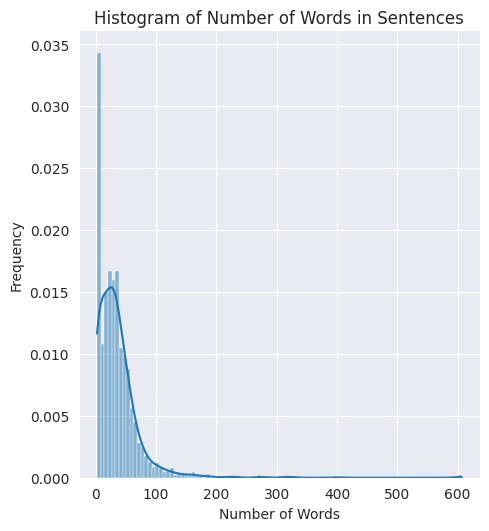

In [6]:
sns.displot(number_of_words_in_sentence, kde=True, stat="density")
plt.xlabel("Number of Words")
plt.ylabel("Frequency")
plt.title("Histogram of Number of Words in Sentences")
plt.show()

Wow! there is a sentence with more that 600 words! let's see what it is:

In [7]:
print(*list(zip(*np.unique(number_of_words_in_sentence, return_counts=True))), sep="\n")

(2, 218)
(3, 3)
(4, 5)
(5, 33)
(6, 23)
(7, 15)
(8, 21)
(9, 19)
(10, 20)
(11, 15)
(12, 12)
(13, 15)
(14, 19)
(15, 18)
(16, 33)
(17, 22)
(18, 23)
(19, 17)
(20, 26)
(21, 27)
(22, 19)
(23, 22)
(24, 34)
(25, 34)
(26, 19)
(27, 18)
(28, 30)
(29, 26)
(30, 29)
(31, 22)
(32, 23)
(33, 26)
(34, 29)
(35, 28)
(36, 25)
(37, 23)
(38, 24)
(39, 15)
(40, 24)
(41, 13)
(42, 18)
(43, 13)
(44, 14)
(45, 19)
(46, 11)
(47, 16)
(48, 19)
(49, 13)
(50, 14)
(51, 18)
(52, 15)
(53, 16)
(54, 9)
(55, 14)
(56, 9)
(57, 8)
(58, 12)
(59, 10)
(60, 7)
(61, 12)
(62, 3)
(63, 6)
(64, 9)
(65, 8)
(66, 8)
(67, 5)
(68, 6)
(69, 4)
(70, 5)
(71, 1)
(72, 5)
(73, 6)
(74, 5)
(75, 6)
(76, 2)
(77, 7)
(78, 1)
(79, 2)
(80, 5)
(81, 4)
(82, 3)
(83, 1)
(84, 3)
(85, 3)
(86, 2)
(87, 2)
(88, 1)
(89, 2)
(90, 1)
(91, 5)
(92, 1)
(93, 1)
(95, 1)
(96, 2)
(97, 3)
(98, 1)
(99, 1)
(100, 1)
(101, 2)
(102, 2)
(103, 2)
(104, 3)
(105, 1)
(106, 2)
(107, 2)
(108, 1)
(110, 1)
(111, 1)
(112, 2)
(114, 1)
(117, 2)
(119, 1)
(120, 2)
(121, 1)
(123, 1)
(124, 1)
(125, 

In [8]:
sentences[number_of_words_in_sentence.index(607)]

'EN 40  EN (3) ‘small -scale provider’ means a provider that is a micro or small enterprise within the \nmeaning of Commission Recommendation 2003/361/EC61; \n(4) ‘user’ means any natural or legal person, public authority, agency or other body \nusing an AI s ystem under its authority, except where the AI system is used in the \ncourse of a personal non -professional activity;  \n(5) ‘authorised representative’ means any natural or legal person established in the \nUnion who has received a written mandate from a provid er of an AI system to, \nrespectively, perform and carry out on its behalf the obligations and procedures \nestablished by this Regulation;  \n(6) ‘importer’ means any natural or legal person established in the Union that places on \nthe market or puts into service  an AI system that bears the name or trademark of a \nnatural or legal person established outside the Union;  \n(7) ‘distributor’ means any natural or legal person in the supply chain, other than the \nprovide

this is in page 40 of the pdf file.

it seems the website has better structure than the pdf file. lets start scraping the website.

# Extract the data from the website

in this part we should consider the following points:
1. the starting url is https://artificialintelligenceact.com/
1. there is no need to do DFS or BFS, we can just use the links in the main page to get to the other pages (other pages may have some links together but there is no need to do that).
1. there is some other links in the main page that are not related to the main content of the website, we should consider the links with this format `^https://artificialintelligenceact.com/title-[ivx]+/.+$` (that [ivx] is a roman number).
1. in the target pages we only consider a `<div>` with `class="container main-content"` and we should ignore the other parts of the page.

to keep this document tidy, I put the code in another file and import it here.
in this code:
- I use `requests` to get the content of the pages
- I use `BeautifulSoup` to parse the html content
- I use `re` to find the links with the above format
- I use `pickle` to save the data in a file (in case of any intruption in the process, I can continue from where I left)
- I use `time` to sleep between requests (to not put too much pressure on the server)
- The output is a list of lists, each list contains one page and the text of the page.


In [9]:
scrapper = Scrapper()
scrapper.unvisited_links

[None, None]

In [10]:
scrapper.scrap()

In [11]:
scrapper.unvisited_links

[None, None]

In [12]:
scrapper.content[0]

['Home » Title I » Article 1',
 '\xa0',
 'This Regulation lays down:',
 '(a) harmonised rules for the placing on the market, the putting into service and the use of artificial intelligence systems (‘AI systems’) in the Union;',
 '(b) prohibitions of certain artificial intelligence practices;',
 '(c) specific requirements for high-risk AI systems and obligations for operators of such systems;',
 '(d) harmonised transparency rules for AI systems intended to interact with natural persons, emotion recognition systems and biometric categorisation systems, and AI systems used to generate or manipulate image, audio or video content;',
 '(e) rules on market monitoring and surveillance.']

# Tokenization

<img src="images/tokenize.jpg" style="height:100">

In [13]:
sentences = []
for page in scrapper.content:
    for p in page:
        sentences.extend(sent_tokenize(p))
sentences

['Home » Title I » Article 1',
 'This Regulation lays down:',
 '(a) harmonised rules for the placing on the market, the putting into service and the use of artificial intelligence systems (‘AI systems’) in the Union;',
 '(b) prohibitions of certain artificial intelligence practices;',
 '(c) specific requirements for high-risk AI systems and obligations for operators of such systems;',
 '(d) harmonised transparency rules for AI systems intended to interact with natural persons, emotion recognition systems and biometric categorisation systems, and AI systems used to generate or manipulate image, audio or video content;',
 '(e) rules on market monitoring and surveillance.',
 'Home » Title I » Article 2',
 '1.',
 'This Regulation applies to:',
 '(a) providers placing on the market or putting into service AI systems in the Union, irrespective of whether those providers are established within the Union or in a third country;',
 '(b) users of AI systems located within the Union;',
 '(c) provi

In [14]:
number_of_words_in_sentence = [len(word_tokenize(sent)) for sent in sentences]
np.unique(number_of_words_in_sentence, return_counts=True)

(array([  2,   3,   4,   5,   6,   7,   8,   9,  10,  11,  12,  13,  14,
         15,  16,  17,  18,  19,  20,  21,  22,  23,  24,  25,  26,  27,
         28,  29,  30,  31,  32,  33,  34,  35,  36,  37,  38,  39,  40,
         41,  42,  43,  44,  45,  46,  47,  48,  49,  50,  51,  52,  53,
         54,  55,  56,  57,  58,  59,  60,  61,  62,  63,  64,  65,  66,
         67,  68,  69,  73,  74,  76,  77,  78,  80,  81,  82,  83,  85,
         86,  90,  93,  95, 119]),
 array([90,  9,  2,  4,  2, 31,  3,  8, 34,  2,  8, 48,  8, 11, 18, 18,  7,
         7, 15, 11,  9, 15, 10,  9, 11, 12, 10,  7, 10,  6,  2,  8, 13,  9,
        10,  8,  5,  5,  8,  9,  6,  9,  5,  3,  5,  6,  1,  7,  2,  4,  2,
         6,  5,  5,  4,  3,  3,  8,  2,  9,  2,  3,  6,  3,  3,  2,  2,  1,
         1,  2,  2,  1,  1,  1,  1,  1,  2,  1,  1,  1,  1,  2,  1]))

we have 94 sentences with two words! let's see what they are:

In [15]:
[s for s in sentences if len(word_tokenize(s)) == 2]

['1.',
 '2.',
 '3.',
 '4.',
 '5.',
 '1.',
 '2.',
 '3.',
 '4.',
 '1.',
 '2.',
 '1.',
 '2.',
 '1.',
 '2.',
 '1.',
 '2.',
 '3.',
 '4.',
 '5.',
 '6.',
 '7.',
 '8.',
 '9.',
 '1.',
 '2.',
 '3.',
 '4.',
 '5.',
 '6.',
 '1.',
 '2.',
 '3.',
 '1.',
 '2.',
 '3.',
 '4.',
 '1.',
 '2.',
 '3.',
 '1.',
 '2.',
 '3.',
 '4.',
 '5.',
 '1.',
 '2.',
 '3.',
 '4.',
 '1.',
 '2.',
 '2a.',
 '3.',
 '1.',
 '1a.',
 '2.',
 '1.',
 '2.',
 '1.',
 '2.',
 '1.',
 '1a.',
 '1b.',
 '2.',
 '1.',
 '2.',
 '3.',
 '4.',
 '5.',
 '1.',
 '2.',
 '3.',
 '4.',
 '5.',
 '1.',
 '2.',
 '1.',
 '2.',
 '3.',
 '4.',
 '5.',
 '6.',
 '1.',
 '2.',
 '3.',
 '4.',
 '5.',
 '6.',
 '7.',
 '8.']

Wow! since they are seperated with dot, tokenizer considers them as two sentences. let's ignore them for now.

In [16]:
sentences = [s for s in sentences if len(word_tokenize(s)) > 2]
number_of_words_in_sentence = [len(word_tokenize(sent)) for sent in sentences]
np.unique(number_of_words_in_sentence, return_counts=True)

(array([  3,   4,   5,   6,   7,   8,   9,  10,  11,  12,  13,  14,  15,
         16,  17,  18,  19,  20,  21,  22,  23,  24,  25,  26,  27,  28,
         29,  30,  31,  32,  33,  34,  35,  36,  37,  38,  39,  40,  41,
         42,  43,  44,  45,  46,  47,  48,  49,  50,  51,  52,  53,  54,
         55,  56,  57,  58,  59,  60,  61,  62,  63,  64,  65,  66,  67,
         68,  69,  73,  74,  76,  77,  78,  80,  81,  82,  83,  85,  86,
         90,  93,  95, 119]),
 array([ 9,  2,  4,  2, 31,  3,  8, 34,  2,  8, 48,  8, 11, 18, 18,  7,  7,
        15, 11,  9, 15, 10,  9, 11, 12, 10,  7, 10,  6,  2,  8, 13,  9, 10,
         8,  5,  5,  8,  9,  6,  9,  5,  3,  5,  6,  1,  7,  2,  4,  2,  6,
         5,  5,  4,  3,  3,  8,  2,  9,  2,  3,  6,  3,  3,  2,  2,  1,  1,
         2,  2,  1,  1,  1,  1,  1,  2,  1,  1,  1,  1,  2,  1]))

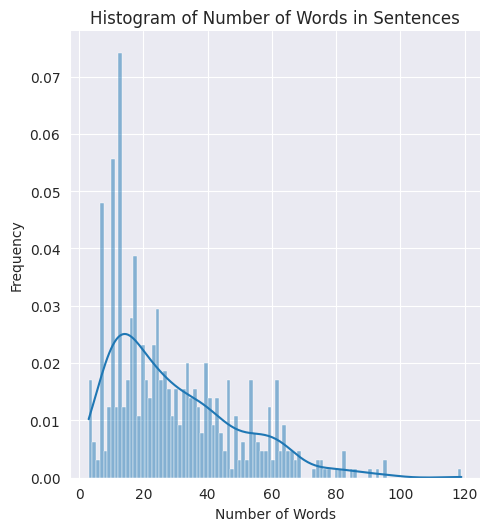

In [17]:
fig = sns.displot(number_of_words_in_sentence, kde=True, stat="density", bins=100)
fig.set(
    xlabel="Number of Words",
    ylabel="Frequency",
    title="Histogram of Number of Words in Sentences",
)
plt.show()

Also, it is important for us to find the number of words in each page.
because the content of each page are somehow realted to each other, we use same data for training.

In [18]:
number_of_words_in_page = []
for page in scrapper.content:
    number_of_words_in_page.append(sum([len(word_tokenize(p)) for p in page]))
np.unique(number_of_words_in_page, return_counts=True)

(array([   7,   10,   13,   36,   44,   50,   51,   55,   56,   60,   66,
          70,   72,   76,   81,   84,   87,   88,   92,   93,   96,   98,
         100,  108,  117,  121,  134,  165,  168,  175,  179,  183,  206,
         218,  225,  233,  237,  253,  269,  271,  282,  308,  314,  336,
         373,  398,  424,  434,  445,  451,  458,  469,  489,  511,  679,
         708,  835,  976, 1940]),
 array([ 5, 14,  5,  1,  1,  1,  1,  1,  1,  2,  1,  1,  1,  1,  1,  1,  1,
         2,  2,  1,  2,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,
         1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,
         1,  2,  1,  1,  1,  1,  1,  1]))

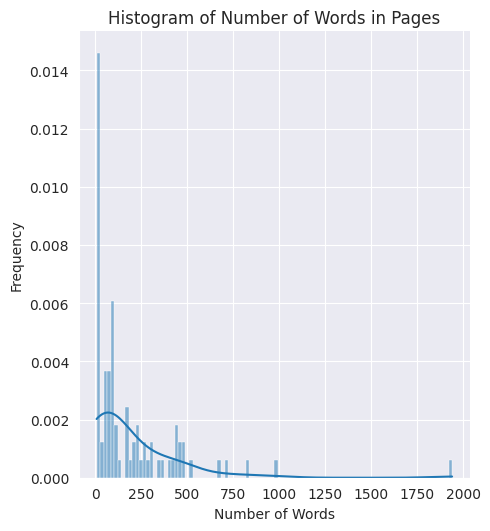

In [19]:
fig = sns.displot(number_of_words_in_page, kde=True, stat="density", bins=100)
fig.set(
    xlabel="Number of Words",
    ylabel="Frequency",
    title="Histogram of Number of Words in Pages",
)
plt.show()

## word count

in this part we should consider the following points:
1. we should remove the punctuations
1. we should remove the stop words
1. we should remove the numbers
1. we should remove the words with length less than 3



In [20]:
# to see the stop words
", ".join(stopwords.words("english"))

"i, me, my, myself, we, our, ours, ourselves, you, you're, you've, you'll, you'd, your, yours, yourself, yourselves, he, him, his, himself, she, she's, her, hers, herself, it, it's, its, itself, they, them, their, theirs, themselves, what, which, who, whom, this, that, that'll, these, those, am, is, are, was, were, be, been, being, have, has, had, having, do, does, did, doing, a, an, the, and, but, if, or, because, as, until, while, of, at, by, for, with, about, against, between, into, through, during, before, after, above, below, to, from, up, down, in, out, on, off, over, under, again, further, then, once, here, there, when, where, why, how, all, any, both, each, few, more, most, other, some, such, no, nor, not, only, own, same, so, than, too, very, s, t, can, will, just, don, don't, should, should've, now, d, ll, m, o, re, ve, y, ain, aren, aren't, couldn, couldn't, didn, didn't, doesn, doesn't, hadn, hadn't, hasn, hasn't, haven, haven't, isn, isn't, ma, mightn, mightn't, mustn, mus

In [21]:
def validate_word(word):
    word = word.lower()
    if word.isalpha() and word not in stopwords.words("english"):
        return word
    return None

In [22]:
scrapper.content[0]

['Home » Title I » Article 1',
 '\xa0',
 'This Regulation lays down:',
 '(a) harmonised rules for the placing on the market, the putting into service and the use of artificial intelligence systems (‘AI systems’) in the Union;',
 '(b) prohibitions of certain artificial intelligence practices;',
 '(c) specific requirements for high-risk AI systems and obligations for operators of such systems;',
 '(d) harmonised transparency rules for AI systems intended to interact with natural persons, emotion recognition systems and biometric categorisation systems, and AI systems used to generate or manipulate image, audio or video content;',
 '(e) rules on market monitoring and surveillance.']

In [23]:
greek_to_english = [
    "i",
    "ii",
    "iii",
    "iv",
    "v",
    "vi",
    "vii",
    "viii",
    "ix",
    "x",
    "xi",
    "xii",
    "xiii",
]

In [24]:
all_words = []
last_article = 0
chapter_counter = []
for page in scrapper.content:
    article_number = (
        greek_to_english.index(
            re.search(r"Home\s.\sTitle(.+?)\s", page[0]).group(1).strip().lower()  # type: ignore
        )
        + 1
    )
    if article_number != last_article:
        # all_words.append(f'zArticle_{article_number}')
        print(page[0], "-->", article_number)
        chapter_counter.append(len(all_words))
        last_article = article_number
    for paragraph in page:
        for word in word_tokenize(paragraph):
            word = validate_word(word)
            if word:
                all_words.append(word)

np.unique(all_words, return_counts=True)

Home » Title I » Article 1 --> 1
Home » Title II » Article 5 --> 2
Home » Title III » Title III | Chapter 1 » Article 6 --> 3
Home » Title IV » Article 52 --> 4
Home » Title V » Article 53 --> 5
Home » Title VI » Title VI | Chapter 1 » Article 56 --> 6
Home » Title VII » Article 60 --> 7
Home » Title VIII » Title VIII | Chapter 1 » Article 61 --> 8
Home » Title IX » Article 69 --> 9
Home » Title X » Article 70 --> 10
Home » Title XI » Article 73 --> 11
Home » Title XII » Article 75 --> 12


(array(['aa', 'ab', 'ability', ..., 'xii', 'year', 'years'], dtype='<U16'),
 array([ 1,  1,  2, ..., 11,  1,  3]))

In [25]:
chapter_counter

[0, 1128, 1582, 6154, 6193, 6456, 6596, 6600, 6836, 6840, 7046, 7054]

In [26]:
words_count = list(zip(*np.unique(all_words, return_counts=True)))
words_count.sort(key=lambda x: x[1], reverse=True)
words_count

[('ai', 237),
 ('system', 229),
 ('article', 183),
 ('shall', 180),
 ('title', 161),
 ('systems', 111),
 ('iii', 106),
 ('chapter', 104),
 ('regulation', 93),
 ('home', 85),
 ('referred', 73),
 ('data', 68),
 ('conformity', 63),
 ('requirements', 63),
 ('market', 61),
 ('use', 59),
 ('technical', 52),
 ('set', 49),
 ('provider', 48),
 ('b', 47),
 ('eu', 47),
 ('paragraph', 47),
 ('means', 46),
 ('purpose', 45),
 ('authorities', 44),
 ('national', 44),
 ('union', 43),
 ('authority', 42),
 ('service', 40),
 ('assessment', 39),
 ('documentation', 39),
 ('ep', 39),
 ('competent', 38),
 ('following', 36),
 ('intended', 36),
 ('agreed', 35),
 ('provisionally', 35),
 ('accordance', 33),
 ('artificial', 33),
 ('intelligence', 33),
 ('providers', 33),
 ('annex', 32),
 ('appropriate', 32),
 ('including', 32),
 ('applicable', 31),
 ('c', 31),
 ('management', 30),
 ('law', 29),
 ('risk', 29),
 ('level', 28),
 ('persons', 28),
 ('relevant', 28),
 ('information', 27),
 ('acts', 26),
 ('member', 26),

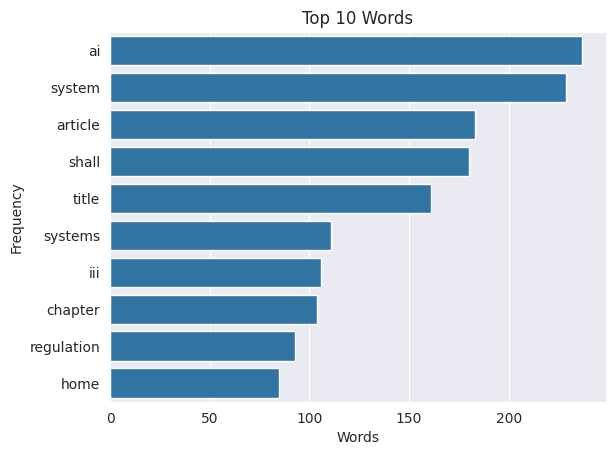

In [27]:
limit = 10
fig = sns.barplot(
    y=[w[0] for w in words_count[:limit]], x=[w[1] for w in words_count[:limit]]
)
fig.set(xlabel="Words", ylabel="Frequency", title=f"Top {limit} Words")
plt.show()

as we can see, there is a word "system" and "systems" in the list. we should consider them as one word. we can use `stemming` or `lemmatization` to do that. I use `LancasterStemmer` because it is more accurate. also, i can use `WordNetLemmatizer` but it is slower.

### lemmatization

In [28]:
wnl = WordNetLemmatizer()
stemmed_words = [wnl.lemmatize(word) for word in all_words]
np.unique(stemmed_words, return_counts=True)

(array(['aa', 'ab', 'ability', ..., 'xi', 'xii', 'year'], dtype='<U16'),
 array([ 1,  1,  2, ...,  2, 11,  4]))

In [29]:
stemmed_words_count_ = list(zip(*np.unique(stemmed_words, return_counts=True)))
stemmed_words_count_.sort(key=lambda x: x[1], reverse=True)
stemmed_words_count = pd.DataFrame(stemmed_words_count_, columns=["word", "count"])
stemmed_words_count

,word,count
0,system,340
1,ai,237
2,article,187
3,shall,180
4,title,161
...,...,...
1163,vulnerable,1
1164,website,1
1165,weight,1
1166,whereas,1


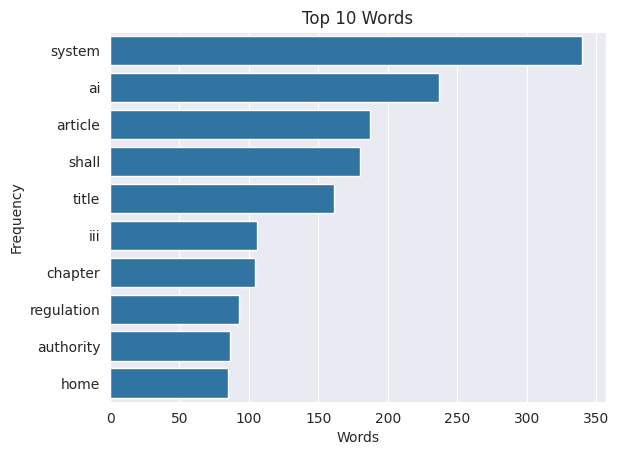

In [30]:
fig = sns.barplot(
    y=stemmed_words_count.iloc[:limit, 0], x=stemmed_words_count.iloc[:limit, 1]
)
fig.set(xlabel="Words", ylabel="Frequency", title=f"Top {limit} Words")
plt.show()

## Word Cloud

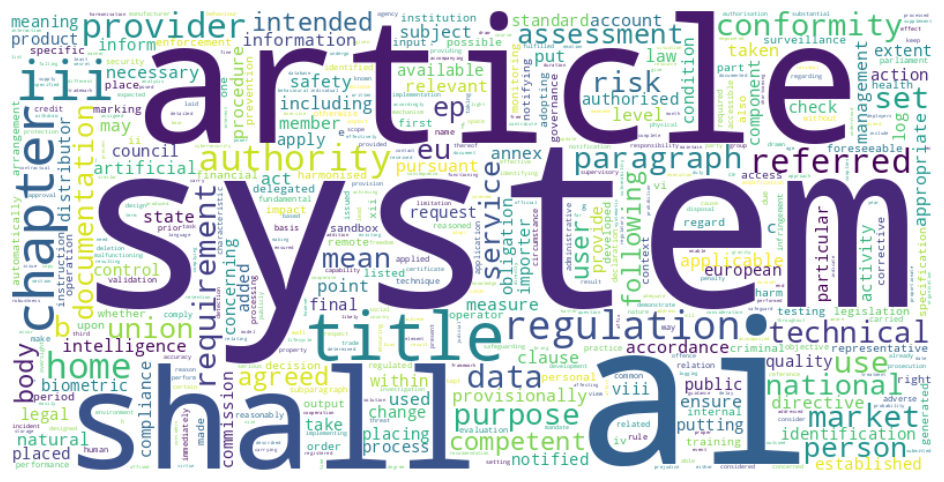

In [31]:
wc = WordCloud(background_color="white", max_words=1000, width=800, height=400)
wc.generate_from_frequencies(stemmed_words_count.set_index("word").to_dict()["count"])
plt.figure(figsize=(12, 6))
plt.imshow(wc, interpolation="bilinear")
plt.axis("off")
plt.show()

- TODO1: I should try different lemmatisers and stemmers to see which one is better. right now we have words such "titl", "chapt", "dat" which sounds not real words.
- TODO2: create a word cloud for each page and see if there is any pattern in the words.
- TODO3: create words density for each page and see if there is any pattern in the words.
- TODO4: perform tf-idf on the words and see if there is any pattern in the words. (we can consider each page as a document)
- TODO5: use a pretrained word2vec model to plot the words in a 2D space.
- TODO6: create new dataset for text-completion and QA models.

- TODO:density of the some words in the document
- TODO: 

# Word embedding and PCA

![](https://miro.medium.com/v2/resize:fit:720/format:webp/1*xD9n3KeWXuenMNL_BpYp6A.png)

## GloVe Word2Vec Embedding

In [32]:
file_path = "glove.6B/glove.6B.50d.txt"
!head $file_path

the 0.418 0.24968 -0.41242 0.1217 0.34527 -0.044457 -0.49688 -0.17862 -0.00066023 -0.6566 0.27843 -0.14767 -0.55677 0.14658 -0.0095095 0.011658 0.10204 -0.12792 -0.8443 -0.12181 -0.016801 -0.33279 -0.1552 -0.23131 -0.19181 -1.8823 -0.76746 0.099051 -0.42125 -0.19526 4.0071 -0.18594 -0.52287 -0.31681 0.00059213 0.0074449 0.17778 -0.15897 0.012041 -0.054223 -0.29871 -0.15749 -0.34758 -0.045637 -0.44251 0.18785 0.0027849 -0.18411 -0.11514 -0.78581
, 0.013441 0.23682 -0.16899 0.40951 0.63812 0.47709 -0.42852 -0.55641 -0.364 -0.23938 0.13001 -0.063734 -0.39575 -0.48162 0.23291 0.090201 -0.13324 0.078639 -0.41634 -0.15428 0.10068 0.48891 0.31226 -0.1252 -0.037512 -1.5179 0.12612 -0.02442 -0.042961 -0.28351 3.5416 -0.11956 -0.014533 -0.1499 0.21864 -0.33412 -0.13872 0.31806 0.70358 0.44858 -0.080262 0.63003 0.32111 -0.46765 0.22786 0.36034 -0.37818 -0.56657 0.044691 0.30392
. 0.15164 0.30177 -0.16763 0.17684 0.31719 0.33973 -0.43478 -0.31086 -0.44999 -0.29486 0.16608 0.11963 -0.41328 -0.42353

In [33]:
pickle_file_path = "word_embeddings.pkl"
if os.path.exists(pickle_file_path):
    print("Loading word embeddings from pickle file")
    with open(pickle_file_path, "rb") as f:
        word_embeddings = pickle.load(f)
else:
    print("Loading word embeddings from txt file")
    word_embeddings = {}
    limit = -1
    with open(file_path, "r") as f:
        for i, line in enumerate(f):
            if i == limit:
                break
            values = line.split()
            word = values[0]
            vector = np.asarray(values[1:], dtype="float32")
            word_embeddings[word] = vector
    print("Saving word embeddings to pickle file")
    with open("word_embeddings.pkl", "wb") as f:
        pickle.dump(word_embeddings, f)

print(len(word_embeddings))

Loading word embeddings from pickle file
400000


In [34]:
top = stemmed_words_count.iloc[:15].copy()
top_embeddings_ = [word_embeddings[w] for w in top.word]
top_embeddings: np.ndarray = np.array(top_embeddings_)
top_embeddings.shape, top_embeddings.dtype

((15, 50), dtype('float32'))

## PCA

PCA is a function that mapps a vector to another vector with less dimensions.

$$
\begin{align*}
f:& \mathbb{R}^n \rightarrow \mathbb{R}^m, m < n \\
& x \rightarrow Mx
\end{align*}
$$

In [35]:
pca = PCA(n_components=2)
top_embeddings_pca = pca.fit_transform(top_embeddings)
top["x"] = top_embeddings_pca[:, 0]
top["y"] = top_embeddings_pca[:, 1]
top

,word,count,x,y
0,system,340,-1.778601,-0.804773
1,ai,237,2.659740,-0.694569
2,article,187,0.387304,0.015135
3,shall,180,0.919919,2.539926
4,title,161,2.925061,-1.077560
5,iii,106,3.110993,-0.372796
6,chapter,104,1.149681,0.218736
7,regulation,93,-1.723554,1.114023
8,authority,86,-1.345178,1.170019
9,home,85,0.334576,-2.272494


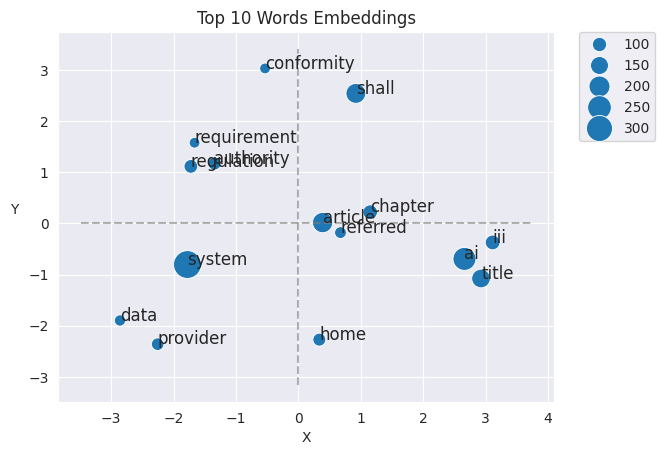

In [36]:
ax = sns.scatterplot(data=top, x="x", y="y", size="count", sizes=(60, 400), legend=True)
ax.set_title("Top 10 Words Embeddings")
ax.set_xlabel("X")
ax.set_ylabel("Y", rotation=0, labelpad=10)

ax.vlines(0, *ax.get_xlim(), colors="gray", alpha=0.6, linestyles="dashed")
ax.hlines(0, *ax.get_ylim(), colors="gray", alpha=0.6, linestyles="dashed")
for i, row in top.iterrows():
    ax.text(row.x, row.y, row.word, fontsize=12)

ax.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.0)
plt.show()

In [37]:
top_norm = top.copy()
max_font_size = 50
min_font_size = 15
min_color = 0.5
max_color = 1
c = top_norm["count"]
top_norm["size"] = (c - c.min()) / (c.max() - c.min()) * (
    max_font_size - min_font_size
) + min_font_size
# top_norm.drop(columns=['count'], inplace=True)
top_norm

,word,count,x,y,size
0,system,340,-1.778601,-0.804773,50.000000
1,ai,237,2.659740,-0.694569,36.985560
2,article,187,0.387304,0.015135,30.667870
3,shall,180,0.919919,2.539926,29.783394
4,title,161,2.925061,-1.077560,27.382671
5,iii,106,3.110993,-0.372796,20.433213
6,chapter,104,1.149681,0.218736,20.180505
7,regulation,93,-1.723554,1.114023,18.790614
8,authority,86,-1.345178,1.170019,17.906137
9,home,85,0.334576,-2.272494,17.779783


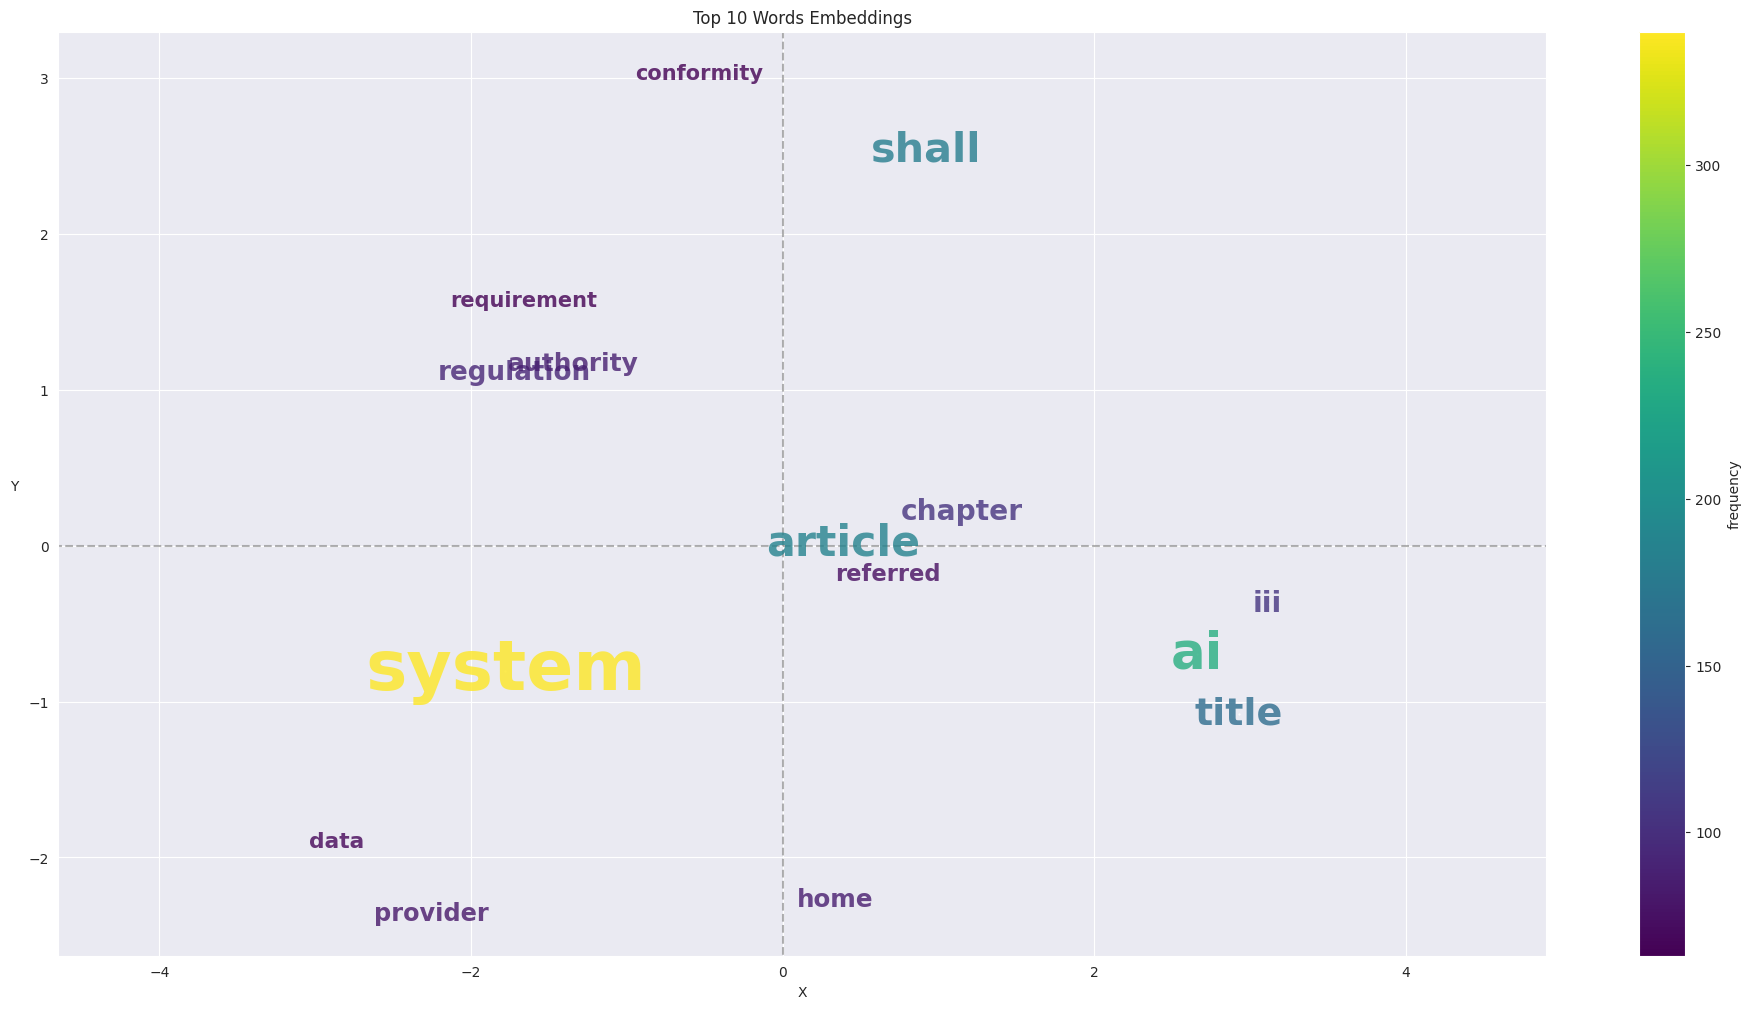

In [38]:
fig, ax = plt.subplots(figsize=(24, 12))

# plt.plot(top_norm.x, top_norm.y, markersize=1, marker=".", linestyle="", cmap=cmap, label = top_norm.word)

# sns.scatterplot(data=top_norm, x='x', y='y', hue='color', sizes=(1,2))
color_norm = Normalize(vmin=top_norm["count"].min(), vmax=top_norm["count"].max())
cmap = colormaps["viridis"]

for i, row in top_norm.iterrows():
    color = cmap(color_norm(row["count"]))
    ax.plot(row.x, row.y, markersize=1, marker=".", linestyle="", color="white")
    ax.text(
        row.x,
        row.y,
        row.word,
        fontsize=row["size"],
        color=color,
        horizontalalignment="center",
        verticalalignment="center",
        alpha=0.8,
        fontweight="bold",
    )


xmin, xmax, ymin, ymax = ax.axis("equal")
ax.vlines(0, xmin * 2, xmax * 2, colors="gray", alpha=0.6, linestyles="dashed")
ax.hlines(0, ymin * 2, ymax * 2, colors="gray", alpha=0.6, linestyles="dashed")
ax.set_xlim(xmin, xmax)
ax.set_ylim(ymin, ymax)
ax.set_title("Top 10 Words Embeddings")
ax.set_xlabel("X")
ax.set_ylabel("Y", rotation=0, labelpad=10)
fig.colorbar(
    ScalarMappable(norm=color_norm, cmap=cmap),
    ax=ax,
    orientation="vertical",
    label="frequency",
)
plt.show()

# Top Words density

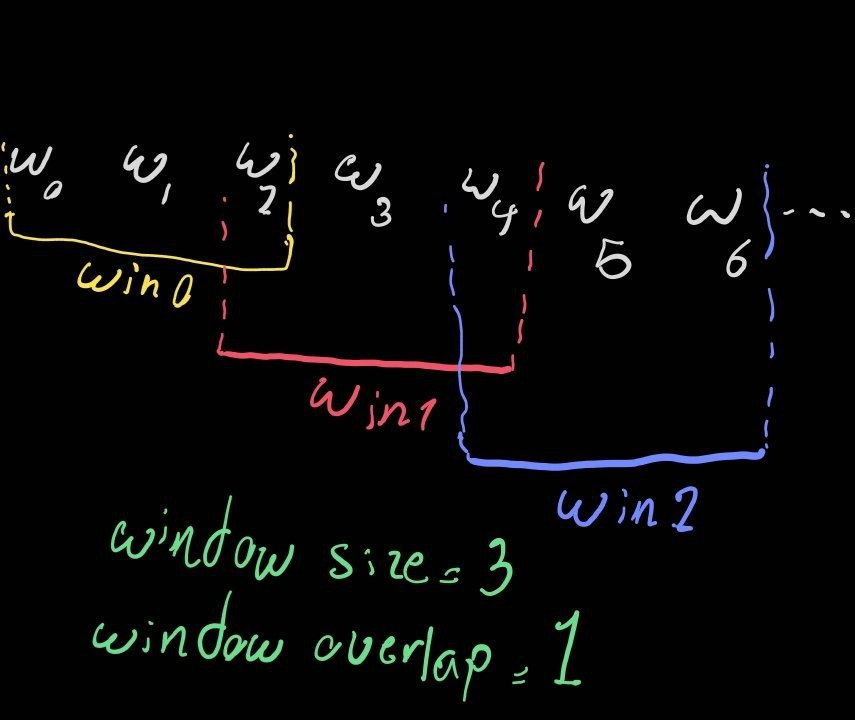

In [39]:
def get_word_density(text: list[str], word: str, window_size: int, overlap: int):
    starting_points = list(range(0, len(text), window_size - overlap))
    return pd.Series(
        [text[s : s + window_size].count(word) for s in starting_points],
        index=starting_points,
        name=word,
    )


get_word_density(
    "lorem amet ipsum dolor sit amet consectetur adipisc amet amet".split(),
    "amet",
    4,
    2,
)

0    1
2    1
4    1
6    2
8    2
Name: amet, dtype: int64

In [40]:
len(stemmed_words)

7601

In [41]:
chapter_counter

[0, 1128, 1582, 6154, 6193, 6456, 6596, 6600, 6836, 6840, 7046, 7054]

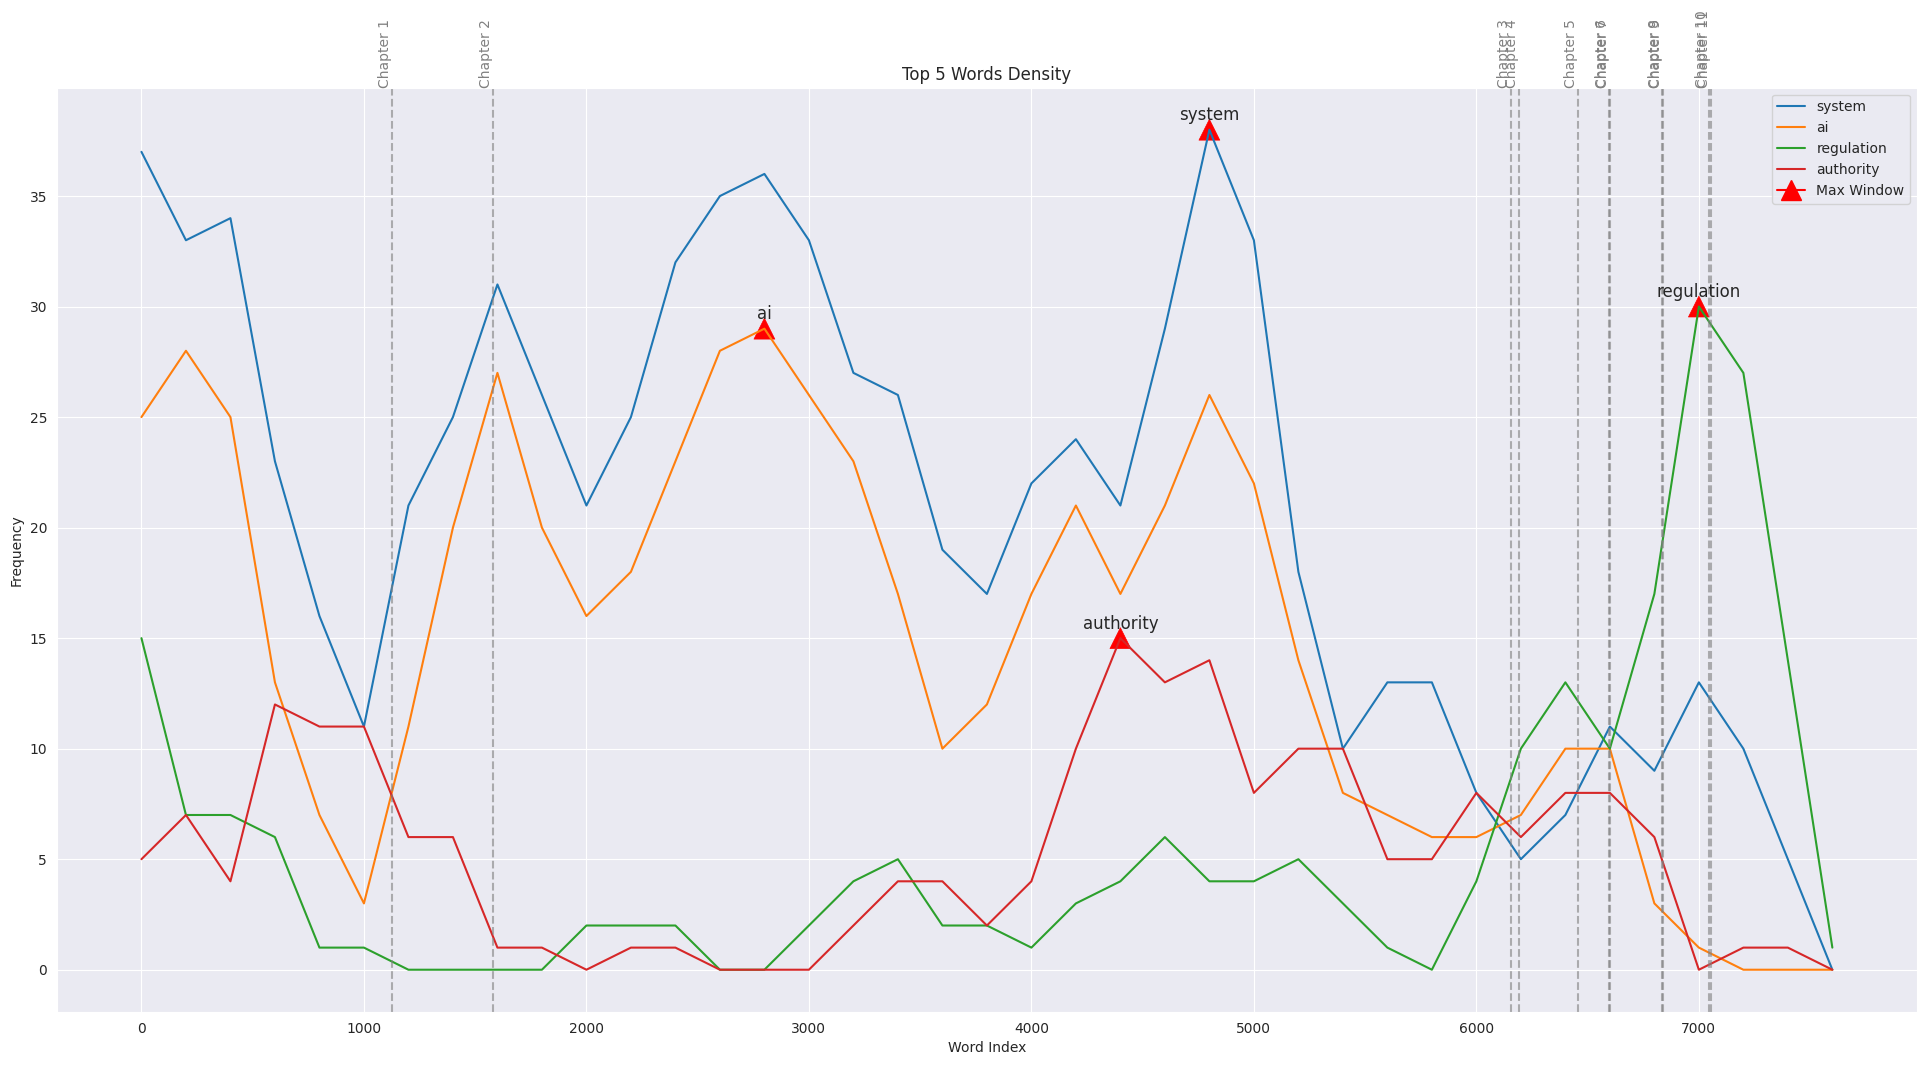

In [42]:
selected_words = ["system", "ai", "regulation", "authority"]

fig, ax = plt.subplots(figsize=(24, 12))
top_words_wnidow_freq = pd.DataFrame(
    get_word_density(stemmed_words, w, window_size=500, overlap=300)
    for w in selected_words
).T
text_locs = pd.DataFrame(
    [top_words_wnidow_freq.max(axis=0), top_words_wnidow_freq.idxmax(axis=0)],
    index=["freq", "index"],
).T.reset_index(names=["word"])

max_marker = "^"
max_color = "red"
max_pointsize = 15

sns.lineplot(data=top_words_wnidow_freq, dashes=False, ax=ax)
(
    so.Plot(text_locs, x="index", y="freq", text="word")
    .add(so.Text(valign="bottom"))
    .add(so.Dot(marker=max_marker, color=max_color, pointsize=max_pointsize))
    .on(ax)
    .plot()
)

for i, chapter_number in enumerate(chapter_counter[1:], start=1):
    ax.axvline(chapter_number, color="gray", alpha=0.6, linestyle="dashed")
    ax.text(
        chapter_number,
        ax.get_ylim()[1],
        f"Chapter {i}",
        rotation=90,
        color="gray",
        ha="right",
        va="bottom",
    )

ax.set_title("Top 5 Words Density")
ax.set_xlabel("Word Index")
ax.set_ylabel("Frequency")

ax.legend(
    handles=[
        art for art in ax.lines if not art.get_label().startswith("_")
    ]  # instead of this list we can simply use ax.lines, but it will also include the legend for the vertical lines and will raise an deprecation warning
    + [
        mlines.Line2D(
            [],
            [],
            color=max_color,
            marker=max_marker,
            markersize=max_pointsize,
            label="Max Window",
        )
    ]
)
ax.grid(True, axis="y")
plt.show()

# Count 2 or 3 seccessive words

In [43]:
a = "kasra"
a.capitalize()

'Kasra'

In [44]:
def find_n_grams(text: list[str], n: int):
    most_freq = pd.Series(
        [tuple(text[i : i + n]) for i in range(len(text) - n + 1)]
    ).value_counts()
    return most_freq


frequent_bigrams = find_n_grams(stemmed_words, 2)
frequent_bigrams = (
    frequent_bigrams.to_frame().reset_index().rename(columns={"index": "bigram"})
)
frequent_bigrams["bigram"] = frequent_bigrams["bigram"].str.join("_")
frequent_bigrams.set_index("bigram").to_dict()["count"]

{'ai_system': 233,
 'title_iii': 91,
 'home_title': 85,
 'iii_chapter': 66,
 'chapter_article': 58,
 'requirement_set': 40,
 'referred_article': 37,
 'provisionally_agreed': 35,
 'artificial_intelligence': 33,
 'regulation_eu': 31,
 'system_shall': 31,
 'competent_authority': 30,
 'conformity_assessment': 29,
 'article_home': 29,
 'national_competent': 26,
 'member_state': 26,
 'intended_purpose': 26,
 'set_chapter': 25,
 'iii_title': 24,
 'clause_provisionally': 22,
 'regulation_shall': 22,
 'put_service': 21,
 'notified_body': 20,
 'chapter_title': 20,
 'technical_level': 20,
 'agreed_ep': 19,
 'technical_documentation': 19,
 'ep_technical': 19,
 'putting_service': 17,
 'natural_person': 17,
 'set_title': 17,
 'management_system': 17,
 'referred_paragraph': 17,
 'market_put': 17,
 'market_putting': 16,
 'chapter_regulation': 16,
 'accordance_article': 16,
 'safety_component': 16,
 'title_viii': 16,
 'placing_market': 16,
 'shall_taken': 15,
 'agreed_subject': 15,
 'final_check': 15,


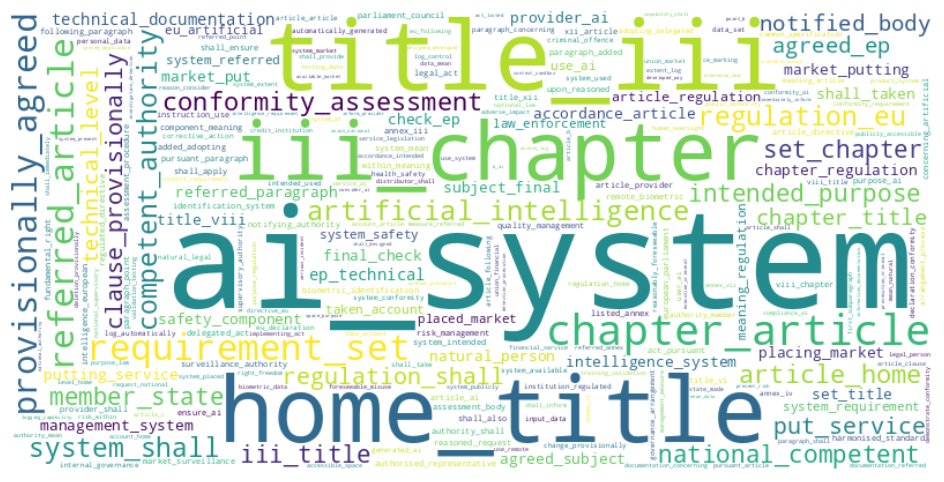

In [45]:
wc = WordCloud(background_color="white", max_words=1000, width=800, height=400)
wc.generate_from_frequencies(frequent_bigrams.set_index("bigram").to_dict()["count"])
plt.figure(figsize=(12, 6))
plt.imshow(wc, interpolation="bilinear")
plt.axis("off")
plt.show()

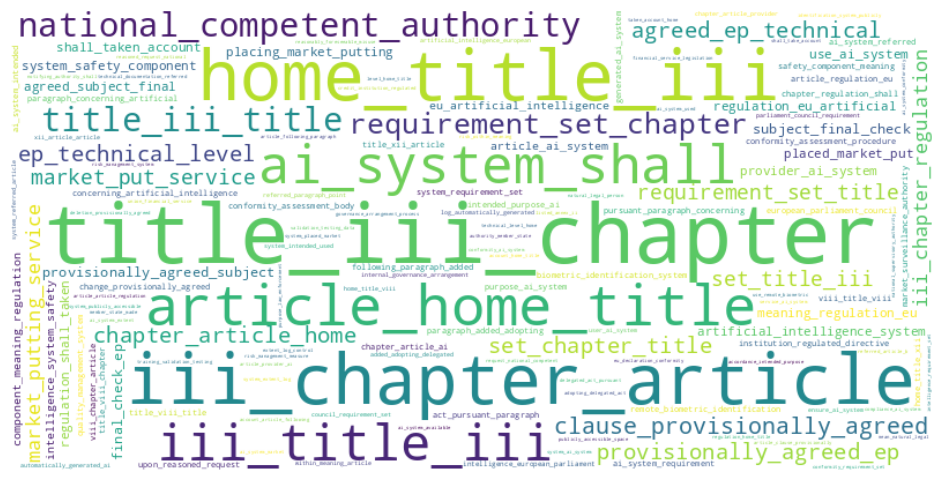

In [46]:
frequent_threegrams = find_n_grams(stemmed_words, 3)
frequent_threegrams = (
    frequent_threegrams.to_frame().reset_index().rename(columns={"index": "threegram"})
)
frequent_threegrams["threegram"] = frequent_threegrams["threegram"].str.join("_")
frequent_threegrams.set_index("threegram").to_dict()["count"]

wc = WordCloud(background_color="white", max_words=1000, width=800, height=400)
wc.generate_from_frequencies(
    frequent_threegrams.set_index("threegram").to_dict()["count"]
)
plt.figure(figsize=(12, 6))
plt.imshow(wc, interpolation="bilinear")
plt.axis("off")
plt.show()

# Sentence Tree


for instance, we have the following sentences:
- I like to eat apple.
- I like to eat banana.
- I like to make pizza.
- I like winter.
- I am a human.

we can create a tree like this:
```mermaid
graph LR
A[I] ==4==> like[like]
A[I] --> E[am]
like --3--> C[to]
C --2--> D[eat]
D --> F[apple]
D --> G[banana]
C --> H[make]
H --> I[pizza]
like --> J[winter]
E --> K[a]
K --> L[human]
```

In [47]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [48]:
start_node = Node("start")
sentences_tmp = (
    "I like to eat apple."
    "I like to eat banana."
    "I like to make pizza."
    "I like winter."
    "I am a human."
    "my name is kasra".split(".")
)
for sent in sentences_tmp:
    node_sum_sent(sent, start_node)
display(Markdown(start_node.print()))

```mermaid
graph LR
N0[start] --4--> N1[like]
N1[like] --2--> N2[eat]
N2[eat] --1--> N3[apple]
N2[eat] --1--> N6[banana]
N1[like] --1--> N8[make]
N8[make] --1--> N9[pizza]
N1[like] --1--> N11[winter]
N0[start] --1--> N12[human]
N0[start] --1--> N13[name]
N13[name] --1--> N14[kasra]
```

as we can see the words "my" and "is" are not in the tree. because they are considered as stop words.

In [49]:
start_node = Node("START")
for _sent in sentences:
    for sent in sent_tokenize(_sent):
        node_sum_sent(sent, start_node)

display(Markdown(start_node.print(min_freq=20)))

```mermaid
graph LR
N15[START] --85--> N16[home]
N16[home] --85--> N17[title]
N17[title] --46--> N1518[iii]
N1518[iii] --24--> N1519[title]
N1519[title] --24--> N1520[iii]
N1520[iii] --24--> N1521[chapter]
N1521[chapter] --24--> N1522[article]
N1518[iii] --22--> N5133[chapter]
N5133[chapter] --22--> N5134[article]
N15[START] --22--> N75[provider]
N15[START] --31--> N106[system]
```

In [50]:
abandoned_words = {
    "home",
    "title",
    "article",
    "chapter",
    "i",
    "ii",
    "iii",
    "iv",
    "v",
    "vi",
    "vii",
    "viii",
    "ix",
    "x",
    "xi",
    "xii",
    "shall",
    "paragraph",
}

start_node = Node("START")
for _sent in sentences:
    for sent in sent_tokenize(_sent):
        node_sum_sent(sent, start_node, abandoned_words)

display(Markdown(start_node.print(min_freq=5)))

```mermaid
graph LR
N7114[START] --18--> N7115[regulation]
N7115[regulation] --5--> N12928[following]
N7114[START] --22--> N7168[provider]
N7168[provider] --7--> N9962[system]
N7114[START] --8--> N7183[user]
N7114[START] --31--> N7199[system]
N7114[START] --7--> N7379[importer]
N7114[START] --8--> N7400[distributor]
N7114[START] --6--> N7425[placing]
N7425[placing] --5--> N7426[market]
N7114[START] --7--> N7583[notifying]
N7583[notifying] --7--> N7584[authority]
N7114[START] --7--> N7600[conformity]
N7600[conformity] --5--> N7601[assessment]
N7114[START] --5--> N7789[testing]
N7114[START] --7--> N8140[following]
N8140[following] --6--> N13102[added]
N7114[START] --6--> N8500[member]
N8500[member] --6--> N8501[state]
N7114[START] --7--> N8702[extent]
N7114[START] --5--> N8837[risk]
N8837[risk] --5--> N8838[management]
N7114[START] --7--> N8980[appropriate]
N7114[START] --9--> N9305[technical]
N9305[technical] --5--> N9306[documentation]
N7114[START] --6--> N10191[clause]
N10191[clause] --6--> N10192[provisionally]
N10192[provisionally] --6--> N10193[agreed]
N10193[agreed] --6--> N10194[technical]
N10194[technical] --6--> N10195[level]
N7114[START] --7--> N10458[council]
N7114[START] --11--> N12931[adopting]
N12931[adopting] --7--> N12963[delegated]
N12963[delegated] --7--> N12964[act]
N12964[act] --7--> N12965[pursuant]
```

In [51]:
display(Markdown((start_node["system"].print(min_freq=3))))
display(Markdown((start_node["provider"].print(min_freq=3))))
display(Markdown((start_node["documentation"].print(min_freq=2))))
display(Markdown((start_node["adopting"].print(min_freq=2))))

```mermaid
graph LR
N7199[system] --4--> N9393[designed]
N9393[designed] --4--> N9394[developed]
N9394[developed] --3--> N9486[way]
N7199[system] --3--> N9447[referred]
N9447[referred] --3--> N9448[point]
N9448[point] --3--> N9449[annex]
N7199[system] --3--> N10893[present]
N10893[present] --3--> N10894[risk]
N10894[risk] --3--> N10895[within]
N10895[within] --3--> N10896[meaning]
```

```mermaid
graph LR
N7168[provider] --7--> N9962[system]
N7168[provider] --3--> N10467[credit]
N10467[credit] --3--> N10468[financial]
N10468[financial] --3--> N10469[institution]
N10469[institution] --3--> N10470[regulated]
N10470[regulated] --3--> N10471[directive]
N10471[directive] --3--> N10472[subject]
N10472[subject] --3--> N10473[requirement]
N10473[requirement] --3--> N10474[regarding]
N10474[regarding] --3--> N10475[internal]
N10475[internal] --3--> N10476[governance]
N10476[governance] --3--> N10477[arrangement]
N10477[arrangement] --3--> N10478[process]
N10478[process] --3--> N10479[union]
N10479[union] --3--> N10480[financial]
N10480[financial] --3--> N10481[service]
N10481[service] --3--> N10482[legislation]
```

```mermaid
graph LR
N10549[documentation] --4--> N10550[concerning]
N10550[concerning] --2--> N10551[quality]
N10551[quality] --2--> N10552[management]
N10552[management] --2--> N10553[system]
N10553[system] --2--> N10554[referred]
N10550[concerning] --2--> N10557[change]
N10557[change] --2--> N10558[approved]
N10558[approved] --2--> N10559[notified]
N10559[notified] --2--> N10560[body]
N10560[body] --2--> N10561[applicable]
```

```mermaid
graph LR
N12931[adopting] --7--> N12963[delegated]
N12963[delegated] --7--> N12964[act]
N12964[act] --7--> N12965[pursuant]
N12965[pursuant] --2--> N12966[first]
N12966[first] --2--> N12967[subparagraph]
N12967[subparagraph] --2--> N12968[concerning]
N12968[concerning] --2--> N12969[artificial]
N12969[artificial] --2--> N12970[intelligence]
N12970[intelligence] --2--> N12971[system]
N12971[system] --2--> N12972[safety]
N12972[safety] --2--> N12973[component]
N12973[component] --2--> N12974[meaning]
N12974[meaning] --2--> N12975[regulation]
N12975[regulation] --2--> N12976[artificial]
N12976[artificial] --2--> N12977[intelligence]
N12977[intelligence] --2--> N12978[european]
N12978[european] --2--> N12979[parliament]
N12979[parliament] --2--> N12980[council]
N12980[council] --2--> N12981[requirement]
N12981[requirement] --2--> N12982[set]
N12982[set] --2--> N12983[regulation]
N12983[regulation] --2--> N12984[taken]
N12984[taken] --2--> N12985[account]
N12965[pursuant] --3--> N13133[paragraph]
N13133[paragraph] --3--> N13134[concerning]
N13134[concerning] --3--> N13135[artificial]
N13135[artificial] --3--> N13136[intelligence]
N13136[intelligence] --3--> N13137[system]
N13137[system] --3--> N13138[safety]
N13138[safety] --3--> N13139[component]
N13139[component] --3--> N13140[meaning]
N13140[meaning] --3--> N13141[regulation]
N13141[regulation] --3--> N13142[artificial]
N13142[artificial] --3--> N13143[intelligence]
N13143[intelligence] --3--> N13144[requirement]
N13144[requirement] --3--> N13145[set]
N13145[set] --3--> N13146[regulation]
N13146[regulation] --3--> N13147[taken]
N13147[taken] --2--> N13148[account]
N12931[adopting] --3--> N13152[implementing]
N13152[implementing] --3--> N13153[act]
N13153[act] --2--> N13154[pursuant]
N13154[pursuant] --2--> N13155[concerning]
N13155[concerning] --2--> N13156[artificial]
N13156[artificial] --2--> N13157[intelligence]
N13157[intelligence] --2--> N13158[system]
N13158[system] --2--> N13159[safety]
N13159[safety] --2--> N13160[component]
N13160[component] --2--> N13161[meaning]
N13161[meaning] --2--> N13162[regulation]
N13162[regulation] --2--> N13163[artificial]
N13163[artificial] --2--> N13164[intelligence]
```

# Sentence Classification
In this part we want to classify the sentences based on their content.
```mermaid
graph TB
S((Start)) --> A[Grab sentence]
A --> B[Classify with ChatGpt\n with list of \navailable classes]
B --> C{If new class} --> |Yes| D[Create new class]
C --> |No| E[Add sentence to the class]
D --> E
E --> A
``` 

In [52]:
classifier = Classifier(
    initil_classes=["information", "warning", "ignore", "title"],
    cache_file="classifier.pkl",
)
classifier.text_classify(sentences, progress_bar=tqdm)

  0%|          | 0/558 [00:00<?, ?it/s]

0

In [53]:
classifier.classes

['information', 'warning', 'ignore', 'title', 'definition']

<Axes: >

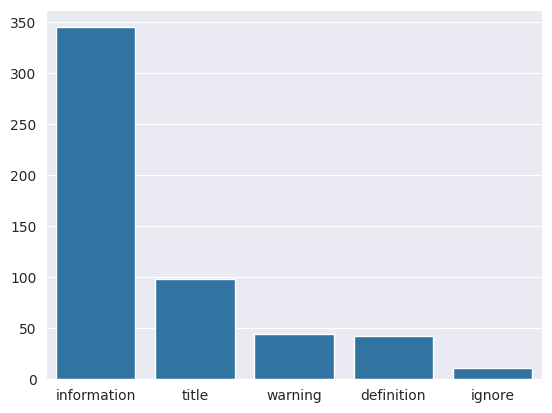

In [54]:
x, y = zip(
    *sorted(
        zip(*np.unique(list(classifier.class_dict.values()), return_counts=True)),
        key=lambda x: x[1],
        reverse=True,
    )
)
sns.barplot(x=x, y=y)

<Axes: >

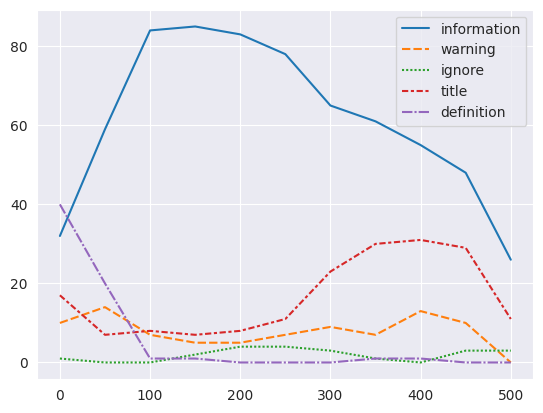

In [55]:
class_density = pd.DataFrame(
    [
        get_word_density(list(classifier.class_dict.values()), cls, 100, 50)
        for cls in classifier.classes
    ]
).T
sns.lineplot(data=class_density)